# ETL - Extract Transform Load

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Extract

## Web Scrapping

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 37
page_size = 100

In [3]:
reviews = []

for i in range(1, pages + 1):
    print(f"Scrapping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
        
    print(len(reviews))

Scrapping page 1
100
Scrapping page 2
200
Scrapping page 3
300
Scrapping page 4
400
Scrapping page 5
500
Scrapping page 6
600
Scrapping page 7
700
Scrapping page 8
800
Scrapping page 9
900
Scrapping page 10
1000
Scrapping page 11
1100
Scrapping page 12
1200
Scrapping page 13
1300
Scrapping page 14
1400
Scrapping page 15
1500
Scrapping page 16
1600
Scrapping page 17
1700
Scrapping page 18
1800
Scrapping page 19
1900
Scrapping page 20
2000
Scrapping page 21
2100
Scrapping page 22
2200
Scrapping page 23
2300
Scrapping page 24
2400
Scrapping page 25
2500
Scrapping page 26
2600
Scrapping page 27
2700
Scrapping page 28
2800
Scrapping page 29
2900
Scrapping page 30
3000
Scrapping page 31
3100
Scrapping page 32
3200
Scrapping page 33
3300
Scrapping page 34
3400
Scrapping page 35
3500
Scrapping page 36
3600
Scrapping page 37
3700


In [4]:
df = pd.DataFrame()
df['reviews'] = reviews
df

,reviews
0,✅ Trip Verified | I have never seen such disr...
1,✅ Trip Verified | Paid for a 14 hour long fli...
2,✅ Trip Verified | Very inconsiderate PA annou...
3,"✅ Trip Verified | Absolutely terrible, lost m..."
4,✅ Trip Verified | We booked premium economy r...
...,...
3695,London (LHR) to Houston (IAH) to London (LHR)....
3696,Travelling from Venice to London Gatwick with ...
3697,LHR-VIE on an A319. Online check-in didn't sta...
3698,We flew LAX to LHR on the new A380-800 in Club...


## Saving The Data

In [5]:
df.to_csv("BA_Reviews.csv")

In [6]:
reviews = pd.read_csv("BA_Reviews.csv")
reviews = reviews.pop('reviews')
reviews

0       ✅ Trip Verified |  I have never seen such disr...
1       ✅ Trip Verified |  Paid for a 14 hour long fli...
2       ✅ Trip Verified |  Very inconsiderate PA annou...
3       ✅ Trip Verified |  Absolutely terrible, lost m...
4       ✅ Trip Verified |  We booked premium economy r...
                              ...                        
3695    London (LHR) to Houston (IAH) to London (LHR)....
3696    Travelling from Venice to London Gatwick with ...
3697    LHR-VIE on an A319. Online check-in didn't sta...
3698    We flew LAX to LHR on the new A380-800 in Club...
3699    LHR-LAX-LHR. This route is the new A380 which ...
Name: reviews, Length: 3700, dtype: object

# 2) Transform

## Cleaning text

In [7]:
def remove_punctuations(text):
    for punctuation in string.punctuation:  # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~   removes these character
        text = text.replace(punctuation, '')
    return text

In [8]:
def remove_short_words(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) > 3]  # Adjust the length condition as needed
    return ' '.join(filtered_words)

In [9]:
reviews = reviews.str.replace('Trip Verified |', '')
reviews = reviews.str.replace('✅', '')
# reviews = reviews.str.replace(r'\b\w{1,3}\b', '')
reviews = reviews.apply(remove_short_words)
reviews = reviews.apply(remove_punctuations)
reviews

0       have never seen such disrespect customer time ...
1       Paid hour long flight ticket which includes in...
2       Very inconsiderate announcements were made pur...
3       Absolutely terrible lost luggage both flights ...
4       booked premium economy round trip from Phoenix...
                              ...                        
3695    London LHR Houston IAH London LHR Heathrow cra...
3696    Travelling from Venice London Gatwick with Bri...
3697    LHRVIE A319 Online checkin didnt start working...
3698    flew A380800 Club World Flight time flight att...
3699    LHRLAXLHR This route A380 which very much look...
Name: reviews, Length: 3700, dtype: object

In [10]:
reviews.shape

(3700,)

In [11]:
freq_words = pd.Series(' '.join(reviews).lower().split()).value_counts()[:50]
freq_words

flight        6637
with          5948
were          4512
that          4363
they          3634
this          3610
have          3369
from          3112
service       2835
very          2825
seat          2352
food          2324
london        2188
british       2188
airways       2164
crew          2150
seats         2087
good          2065
time          2060
cabin         1973
class         1922
which         1914
there         1763
business      1610
when          1601
staff         1563
heathrow      1521
would         1514
only          1497
their         1488
economy       1426
first         1300
after         1271
flights       1196
more          1157
been          1134
just          1110
return        1106
other         1099
club          1080
back          1077
hours         1068
than          1068
passengers    1050
again         1046
plane         1040
airline       1039
verified      1034
even          1014
them          1013
Name: count, dtype: int64

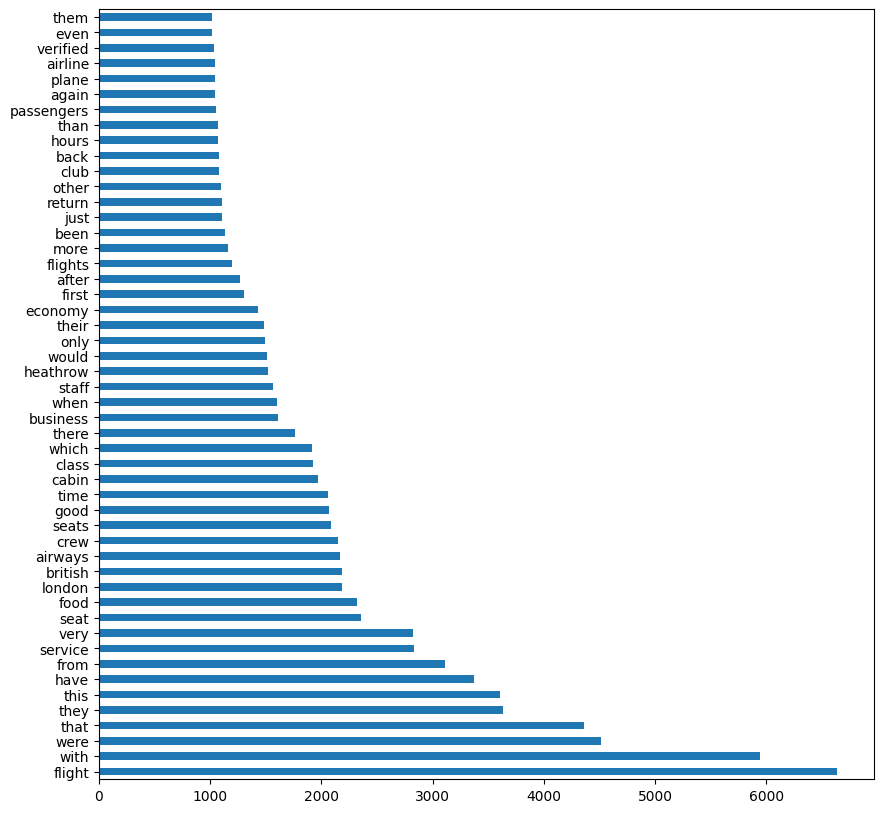

In [12]:
plt.figure(figsize=(10,10))
freq_words.plot.barh(x=freq_words[0], y=freq_words[1])
plt.show()

## Text Clustering

In [13]:
cat = ['positive', 'negative']
num_cat = len(cat)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

tf_idf_vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = tokenizer.tokenize)

# 3) Load

In [15]:
review_counts = tf_idf_vect.fit_transform(reviews)

review_counts.shape

c:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3700, 14766)

## KMeans

In [17]:
from sklearn.cluster import KMeans

Kmeans = KMeans(n_clusters=num_cat).fit(review_counts)

pred_labels = Kmeans.labels_
pred_labels

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, ..., 0, 1, 1])

In [18]:
cluster_centres = Kmeans.cluster_centers_
cluster_centres

array([[6.63692465e-05, 0.00000000e+00, 1.78394969e-04, ...,
        0.00000000e+00, 0.00000000e+00, 6.31089539e-05],
       [0.00000000e+00, 6.99348528e-05, 0.00000000e+00, ...,
        6.08433265e-05, 8.92685087e-05, 0.00000000e+00]])

In [19]:
unique, count = np.unique(pred_labels, return_counts=True)
dict(zip(unique, count))   # positive and negative features

{0: 1442, 1: 2258}

In [20]:
from sklearn import metrics

dbi = metrics.davies_bouldin_score(review_counts.toarray(), pred_labels)

ss = metrics.silhouette_score(review_counts.toarray(), pred_labels, metric='euclidean')

# Both of these gives clustering scores
# how similar an object is to its own cluster compared to other clusters. 

print("DBI Score: ", dbi)
print("Silhoutte score: ", ss)

DBI Score:  12.563335953786448
Silhoutte score:  0.006574927187218888


## Hierarchical Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Apply Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=num_cat)
agg_clusters = agg_clustering.fit_predict(review_counts.toarray())

# Evaluate clustering performance using silhouette score
agg_silhouette_avg = silhouette_score(review_counts, agg_clusters)
print("Hierarchical Clustering Silhouette Score:", agg_silhouette_avg)

# Evaluate clustering performance using Davies-Bouldin score
db_score_agg = davies_bouldin_score(review_counts.toarray(), agg_clusters)
print("Hierarchical Clustering Davies-Bouldin Score:", db_score_agg)


Hierarchical Clustering Silhouette Score: 0.004986862277875568
Hierarchical Clustering Davies-Bouldin Score: 14.273690659384608


## Gaussian Mixture Models (GMM)

Took to much memory, device and colab can't handle

In [28]:
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score, davies_bouldin_score

# # Apply Gaussian Mixture Models
# gmm = GaussianMixture(n_components=num_cat)
# gmm.fit(review_counts.toarray())
# gmm_clusters = gmm.predict(review_counts.toarray())

# # Evaluate clustering performance using silhouette score
# gmm_silhouette_avg = silhouette_score(review_counts, gmm_clusters)
# print("GMM Silhouette Score:", gmm_silhouette_avg)

# # Davies-Bouldin Score for Gaussian Mixture Models
# db_score_gmm = davies_bouldin_score(review_counts.toarray(), gmm_clusters)
# print("GMM Davies-Bouldin Score:", db_score_gmm)


## Mean-Shift

Took to much memory, device and colab can't handle

In [29]:
# from sklearn.cluster import MeanShift
# from sklearn.metrics import silhouette_score, davies_bouldin_score

# # Apply Mean Shift
# mean_shift = MeanShift()
# mean_shift_clusters = mean_shift.fit_predict(review_counts.toarray())

# # Evaluate clustering performance using silhouette score
# mean_shift_silhouette_avg = silhouette_score(review_counts, mean_shift_clusters)
# print("Mean Shift Silhouette Score:", mean_shift_silhouette_avg)

# # Davies-Bouldin Score for Mean Shift
# db_score_mean_shift = davies_bouldin_score(review_counts.toarray(), mean_shift_clusters)
# print("Mean Shift Davies-Bouldin Score:", db_score_mean_shift)


Higher Silhouette Score is preferred and Lower Davies-Bouldin Score is preferred <br /> 
Therefore the best model among the tested models is K-Means

## Visulaizing Results

In [31]:
df_reviews = pd.DataFrame({'review': reviews, 'label': pred_labels})
df_reviews

,review,label
0,have never seen such disrespect customer time ...,0
1,Paid hour long flight ticket which includes in...,0
2,Very inconsiderate announcements were made pur...,0
3,Absolutely terrible lost luggage both flights ...,0
4,booked premium economy round trip from Phoenix...,0
...,...,...
3695,London LHR Houston IAH London LHR Heathrow cra...,0
3696,Travelling from Venice London Gatwick with Bri...,0
3697,LHRVIE A319 Online checkin didnt start working...,0
3698,flew A380800 Club World Flight time flight att...,1


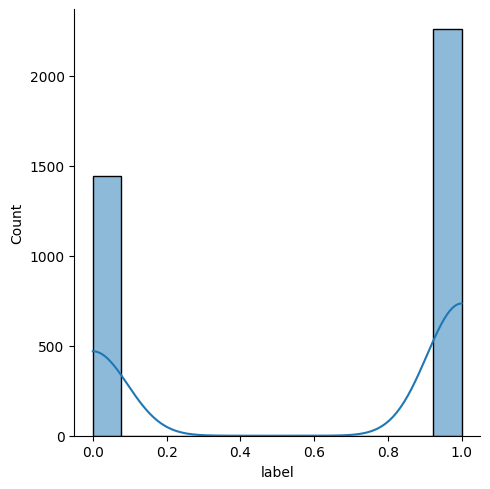

In [32]:
sns.displot(df_reviews['label'], kde=True)

In [33]:
positive_reviews = df_reviews[df_reviews['label'] == 1]
positive_reviews

,review,label
9,Check fast friendly Security breeze Lounge bus...,1
10,This first time have seen Club World suite sea...,1
11,Flew business class from Doha London 31st Marc...,1
12,Starting Heathrow Terminal Check fairly easy f...,1
14,last minute business trip HND route regularly ...,1
...,...,...
3690,Rome Fiumicino Economy Airbus 321 Great staff ...,1
3692,Boston very busy check fast efficient flight a...,1
3694,Return Outbound flight delayed hours just well...,1
3698,flew A380800 Club World Flight time flight att...,1


In [34]:
negative_reviews = df_reviews[df_reviews['label'] == 0]
negative_reviews

,review,label
0,have never seen such disrespect customer time ...,0
1,Paid hour long flight ticket which includes in...,0
2,Very inconsiderate announcements were made pur...,0
3,Absolutely terrible lost luggage both flights ...,0
4,booked premium economy round trip from Phoenix...,0
...,...,...
3691,OSLLHR June 8th days after arriving departed s...,0
3693,outward trip Manchester Heathrow Milan fine wi...,0
3695,London LHR Houston IAH London LHR Heathrow cra...,0
3696,Travelling from Venice London Gatwick with Bri...,0


# Saving Model

In [36]:
import joblib

joblib.dump(Kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

In [37]:
joblib.dump(tf_idf_vect, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## Testing the model

In [41]:
import joblib

# Load the saved K-Means model
loaded_kmeans = joblib.load('kmeans_model.pkl')

# Load the saved TF-IDF vectorizer
loaded_tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Example strings to test
example_strings = [
    "The business class cabin of flight was great, the attendants were polite and the flight was awesome",
    "Absolutely terrible flight, worst service ever"
]

# Transform the example strings into TF-IDF vectors using the loaded vectorizer
tfidf_matrix_test = loaded_tfidf_vectorizer.transform(example_strings)

# Predict the clusters for the TF-IDF vectors using the loaded K-Means model
predicted_clusters = loaded_kmeans.predict(tfidf_matrix_test)

# Print the predicted clusters for each example string
for string, cluster in zip(example_strings, predicted_clusters):
    print(f"String: '{string}' --> Predicted Cluster: {cluster}")


String: 'The business class cabin of flight was great, the attendants were polite and the flight was awesome' --> Predicted Cluster: 1
String: 'Absolutely terrible flight, worst service ever' --> Predicted Cluster: 0
